## Import packages

In [1]:
import pandas as pd
import os
import numpy
import pyLDAvis
import pyLDAvis.gensim
import numpy as np
import pandas as pd
import re
from multiprocessing import Pool
from joblib import Parallel, delayed
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from gensim.models.coherencemodel import CoherenceModel

## Read file containing all videos captioned

In [2]:
df = pd.read_csv("/Users/shaunakjoshi/DL_work/attention_fusion_default_networks_pairwise_21epochs/lda_preds.csv")
df

Video path  \
0    ['/home/shaunaks/cls_data_1_min/encoded_videos...   
1    ['/home/shaunaks/cls_data_1_min/encoded_videos...   
2    ['/home/shaunaks/cls_data_1_min/encoded_videos...   
3    ['/home/shaunaks/cls_data_1_min/encoded_videos...   
4    ['/home/shaunaks/cls_data_1_min/encoded_videos...   
..                                                 ...   
326  ['/home/shaunaks/cls_data_1_min/encoded_videos...   
327  ['/home/shaunaks/cls_data_1_min/encoded_videos...   
328  ['/home/shaunaks/cls_data_1_min/encoded_videos...   
329  ['/home/shaunaks/cls_data_1_min/encoded_videos...   
330  ['/home/shaunaks/cls_data_1_min/encoded_videos...   

                                               Caption  Prediction_from_lda  
0     a video of a bridge that is over a highway. a...                  NaN  
1     a car is driving down a road and a man is tal...                  NaN  
2     a person is walking up a staircase and then a...                  NaN  
3     a man is squatting down and then he picks up ...                  NaN  
4     a man in a knight's armor is talking to anoth...                  NaN  
..                                                 ...                  ...  
326   a man is sitting at a table and talking to th...                  NaN  
327   a man is holding a box that is being held by ...                  NaN  
328   a man in a wheelchair is sitting in a room an...                  NaN  
329   a little girl is laying down and a cat is lay...                  NaN  
330   a couple is driving in a car and then they ar...                  NaN  

[331 rows x 3 columns]

## Preprocess Data

In [3]:
df['Caption'] = \
df['Caption'].map(lambda x: re.sub('[,\.!?]', '', x))
df['Caption'] = \
df['Caption'].map(lambda x: x.lower())
df['Caption'].head()

<>:2: DeprecationWarning: invalid escape sequence '\.'
<>:2: DeprecationWarning: invalid escape sequence '\.'
/var/folders/sn/mrzhg2jd1339hmr4nh4z_dxr0000gn/T/ipykernel_20034/1509625820.py:2: DeprecationWarning: invalid escape sequence '\.'
  df['Caption'].map(lambda x: re.sub('[,\.!?]', '', x))


0     a video of a bridge that is over a highway a ...
1     a car is driving down a road and a man is tal...
2     a person is walking up a staircase and then a...
3     a man is squatting down and then he picks up ...
4     a man in a knight's armor is talking to anoth...
Name: Caption, dtype: object

In [4]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#print(stop_words)

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts, keep_sentence=False):
    if not keep_sentence:
        return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
    else:
        return [' '.join([word for word in simple_preprocess(str(doc)) 
             if word not in stop_words]) for doc in texts]
        

data = df.Caption.values.tolist()
data_words = list(sent_to_words(data))
data_words = remove_stopwords(data_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shaunakjoshi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
import plotly.graph_objects as go
import gensim.corpora as corpora


id2word = corpora.Dictionary(data_words)
texts = data_words
import collections
from collections import defaultdict
word_to_count = collections.Counter()

for i, text in enumerate(texts):
    temp_dict = collections.Counter(text)
    word_to_count.update(temp_dict)
word_to_count = dict(sorted(word_to_count.items(), key=lambda item: item[1], reverse=True))
corpus = [id2word.doc2bow(text) for text in texts]


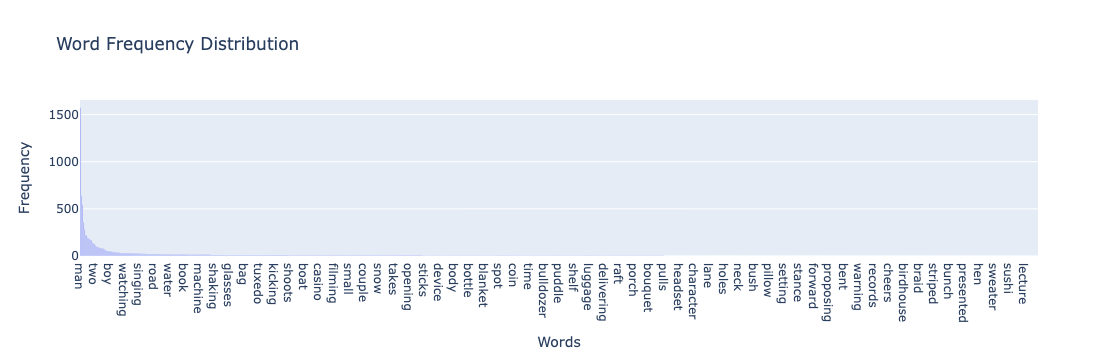

In [6]:
words = list(word_to_count.keys())
count_ = list(word_to_count.values())
fig = go.Figure(data=[go.Bar(x=words, y=count_)])
fig.update_layout(
    title='Word Frequency Distribution',
    xaxis_title='Words',
    yaxis_title='Frequency',
    bargap=0.2 # Adjusts the gap between bars
)
fig.show()

In [7]:
fig.write_html('LDA_MLP_visualizations/corpus_distribution.html')

## Visualize LDA on corpus using only 10 topics

In [8]:
num_topics = 10
lda_model_copy = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                      random_state = np.random.RandomState(42))
print(lda_model_copy.num_topics)

10


In [9]:
lda_model_copy_asymmetric = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       alpha='asymmetric',
                                       eta='auto',
                                      random_state = np.random.RandomState(42))


In [10]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(lda_model_copy, corpus, id2word, mds='mmds')
p

/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.040006  0.069314       1        1  31.249131
6      0.010268  0.082317       2        1  16.527806
3     -0.047131  0.120427       3        1  10.944417
7     -0.057593  0.024428       4        1   9.197137
0      0.044248 -0.006420       5        1   9.176502
2      0.108435 -0.001578       6        1   7.590271
1      0.097504  0.099820       7        1   6.594535
9      0.080953 -0.092804       8        1   5.380874
8     -0.024960 -0.097441       9        1   3.043631
4     -0.171717 -0.198063      10        1   0.295695, topic_info=        Term         Freq        Total Category  logprob  loglift
5        man  1467.000000  1467.000000  Default  30.0000  30.0000
2        car   193.000000   193.000000  Default  29.0000  29.0000
27     woman   512.000000   512.000000  Default  28.0000  28.0000
8      shown   162.000000   162.000000  Default  27.0000  27.0000
9    sitting   339.000000   339.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
51       two     0.032979   103.122532  Topic10  -6.8654  -2.2242
72    around     0.032978    77.738722  Topic10  -6.8654  -1.9417
15   driving     0.032975    82.225869  Topic10  -6.8655  -1.9979
20   holding     0.032975    93.058960  Topic10  -6.8655  -2.1217
391    table     0.032972    81.756599  Topic10  -6.8655  -1.9922

[685 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
844       2  0.562955    action
633       4  0.554277     actor
633       9  0.184759     actor
337       2  0.562956    adjust
372       7  0.558256   adjusts
...     ...       ...       ...
353       5  0.357282   working
353       9  0.119094   working
720       4  0.561666  workshop
255       1  0.301168    yellow
255       5  0.602337    yellow

[1204 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 4, 8, 1, 3, 2, 10, 9, 5])

In [11]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(lda_model_copy_asymmetric, corpus, id2word, mds='mmds')
p

/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.030813 -0.117596       1        1  27.457061
0     -0.012551 -0.017328       2        1  19.629529
6     -0.003529 -0.105586       3        1  13.717593
3      0.064691 -0.031915       4        1  10.602190
1      0.109448 -0.054113       5        1   8.773966
2     -0.076486 -0.075050       6        1   8.583954
7      0.082171  0.033993       7        1   5.195646
9     -0.125784  0.017083       8        1   4.102737
8     -0.059368  0.096032       9        1   1.671646
4     -0.009406  0.254479      10        1   0.265677, topic_info=        Term         Freq        Total Category  logprob  loglift
27     woman   512.000000   512.000000  Default  30.0000  30.0000
5        man  1468.000000  1468.000000  Default  29.0000  29.0000
2        car   194.000000   194.000000  Default  28.0000  28.0000
8      shown   163.000000   163.000000  Default  27.0000  27.0000
9    sitting   339.000000   339.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
111   laying     0.029619    55.582104  Topic10  -6.8658  -1.6066
94    street     0.029619    62.994147  Topic10  -6.8658  -1.7317
19       gun     0.029618    45.680827  Topic10  -6.8658  -1.4104
362    chair     0.029618    50.994878  Topic10  -6.8658  -1.5205
62     large     0.029618    32.570676  Topic10  -6.8658  -1.0721

[684 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
844       3  0.556242  action
633       2  0.383866   actor
633       5  0.191933   actor
633       7  0.383866   actor
337       3  0.556092  adjust
...     ...       ...     ...
410       4  0.089158   young
410       5  0.044579   young
410       6  0.044579   young
410       7  0.133737   young
410       8  0.089158   young

[1158 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 7, 4, 2, 3, 8, 10, 9, 5])

In [12]:
vars(lda_model_copy)

{'workers': 7,
 'batch': False,
 'dtype': dtype('float32'),
 'id2word': <gensim.corpora.dictionary.Dictionary at 0x3003bfb10>,
 'num_terms': 959,
 'distributed': False,
 'num_topics': 10,
 'chunksize': 2000,
 'decay': 0.5,
 'offset': 1.0,
 'minimum_probability': 0.01,
 'num_updates': 331,
 'passes': 1,
 'update_every': 1,
 'eval_every': 10,
 'minimum_phi_value': 0.01,
 'per_word_topics': False,
 'callbacks': None,
 'alpha': array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], dtype=float32),
 'optimize_alpha': False,
 'eta': array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
        0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
        0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
        0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
        0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
        0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
        0.1, 0.1, 0.1, 0.1,

In [13]:
vars(lda_model_copy_asymmetric)

{'workers': 7,
 'batch': False,
 'dtype': dtype('float32'),
 'id2word': <gensim.corpora.dictionary.Dictionary at 0x3003bfb10>,
 'num_terms': 959,
 'distributed': False,
 'num_topics': 10,
 'chunksize': 2000,
 'decay': 0.5,
 'offset': 1.0,
 'minimum_probability': 0.01,
 'num_updates': 331,
 'passes': 1,
 'update_every': 1,
 'eval_every': 10,
 'minimum_phi_value': 0.01,
 'per_word_topics': False,
 'callbacks': None,
 'alpha': array([0.20349778, 0.15460682, 0.12465747, 0.10442834, 0.08984803,
        0.07884031, 0.07023542, 0.06332404, 0.057651  , 0.05291085],
       dtype=float32),
 'optimize_alpha': False,
 'eta': array([0.19822885, 0.13153389, 0.19345143, 0.15657851, 0.1337688 ,
        0.21460816, 0.16699213, 0.15662017, 0.19657502, 0.20210859,
        0.20603344, 0.16391374, 0.1936901 , 0.10925163, 0.13680336,
        0.17524904, 0.13717337, 0.1234398 , 0.11879061, 0.1780585 ,
        0.18649128, 0.12127674, 0.14017811, 0.11963142, 0.1085097 ,
        0.17565075, 0.15681791, 0.203250

In [14]:
#pyLDAvis.save_html(p, 'lda_model_baseline_10_topics.html')

## Find the best topic size

In [15]:
def find_best_topic(corpus, id2word, data_words):
    max_topic = None
    max_coherence = -1
    
    def get_coherence(topic):
        lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=topic,
                                              random_state = np.random.RandomState(42), workers=1)
        
        coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v', processes=1)
        coherence_lda = coherence_model_lda.get_coherence()
        print(f'Coherence Score: {coherence_lda} and num_topics: {topic}')    
        return topic, coherence_lda 
    
    pool = Parallel(n_jobs=-1)
    topic_range = range(1, 150)
    #all_results = pool.map(get_coherence, topic_range)
    all_results = pool(delayed(get_coherence)(topic) for topic in topic_range)
    # pool.close()
    # pool.join()
    
    for topic, coherence_score in all_results:
        if coherence_score > max_coherence:
            max_coherence = coherence_score
            max_topic = topic
    print(f'Max topic:{max_topic} with coherence score: {max_coherence}')
    return max_topic, max_coherence

In [16]:
max_topic, _ = find_best_topic(corpus, id2word, data_words)

Coherence Score: 0.32969835213527 and num_topics: 1
Coherence Score: 0.3448001767007264 and num_topics: 5
Coherence Score: 0.33622010105102584 and num_topics: 4
Coherence Score: 0.33279143837384867 and num_topics: 3
Coherence Score: 0.3228161050467428 and num_topics: 6
Coherence Score: 0.32754050492213843 and num_topics: 2
Coherence Score: 0.3574028286955981 and num_topics: 8
Coherence Score: 0.33029904291700035 and num_topics: 7
Coherence Score: 0.3403169100178377 and num_topics: 9
Coherence Score: 0.35192690160701956 and num_topics: 10
Coherence Score: 0.36729469889909083 and num_topics: 11
Coherence Score: 0.32956359831175336 and num_topics: 14
Coherence Score: 0.3570924615597583 and num_topics: 12
Coherence Score: 0.36557435966704654 and num_topics: 13
Coherence Score: 0.33493085238627696 and num_topics: 15
Coherence Score: 0.3207739247422121 and num_topics: 16
Coherence Score: 0.33098540166517904 and num_topics: 17
Coherence Score: 0.3214242343109146 and num_topics: 18
Coherence S

In [17]:
from pprint import pprint
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=max_topic,
                                      random_state = np.random.RandomState(42))
# pprint(lda_model.print_topics())
# print(lda_model)
# doc_lda = lda_model[corpus]
print(lda_model.num_topics)

109


In [18]:
#Visualize using mmds as multidimentionality reduction technique
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds') 
p

/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
40     0.000214  0.173039       1        1  10.370941
32     0.063303  0.298138       2        1   6.544355
77    -0.130572  0.291666       3        1   5.403152
47     0.059418  0.201700       4        1   4.848810
70    -0.051582  0.177531       5        1   3.997291
...         ...       ...     ...      ...        ...
79     0.024709 -0.238081     105        1   0.027212
78     0.021099 -0.213122     106        1   0.027212
67     0.024709 -0.238081     107        1   0.027212
76     0.024709 -0.238081     108        1   0.027212
54     0.024709 -0.238081     109        1   0.027212

[109 rows x 5 columns], topic_info=        Term         Freq        Total  Category  logprob  loglift
5        man  1462.000000  1462.000000   Default  30.0000  30.0000
2        car   209.000000   209.000000   Default  29.0000  29.0000
27     woman   516.000000   516.000000   Default  28.0000  28.0000
10   talking   617.000000   617.000000   Default  27.0000  27.0000
9    sitting   330.000000   330.000000   Default  26.0000  26.0000
..       ...          ...          ...       ...      ...      ...
25      seen     0.003033    26.709867  Topic109  -6.8659  -0.8739
26  shooting     0.003033    21.077153  Topic109  -6.8659  -0.6370
27     woman     0.003033   516.102336  Topic109  -6.8659  -3.8351
28      arts     0.003033    25.451925  Topic109  -6.8659  -0.8256
29       bag     0.003033     8.126090  Topic109  -6.8659   0.3161

[5453 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
833       2  0.796674  accident
751       1  0.303830    across
751      28  0.303830    across
844       2  0.780679    action
633       2  0.358838     actor
...     ...       ...       ...
410      30  0.103930     young
410      31  0.051965     young
410      37  0.051965     young
410      51  0.051965     young
410      71  0.051965     young

[4029 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[41, 33, 78, 48, 71, 105, 88, 63, 74, 76, 19, 43, 66, 4, 6, 61, 90, 18, 44, 54, 12, 29, 108, 104, 28, 86, 7, 8, 81, 72, 37, 42, 1, 56, 82, 59, 3, 46, 57, 89, 24, 99, 62, 73, 45, 96, 22, 83, 91, 9, 2, 17, 87, 103, 65, 58, 47, 49, 10, 70, 40, 31, 21, 97, 106, 85, 67, 51, 20, 16, 30, 84, 11, 109, 25, 38, 13, 75, 100, 95, 27, 26, 98, 101, 93, 102, 23, 15, 14, 107, 5, 94, 92, 69, 32, 34, 35, 36, 39, 50, 52, 53, 60, 64, 80, 79, 68, 77, 55])

In [19]:
from pprint import pprint
lda_model_asymmetric = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=max_topic,
                                       alpha = 'asymmetric',
                                        eta='auto',
                                      random_state = np.random.RandomState(42))

In [20]:
vars(lda_model_asymmetric)

{'workers': 7,
 'batch': False,
 'dtype': dtype('float32'),
 'id2word': <gensim.corpora.dictionary.Dictionary at 0x3003bfb10>,
 'num_terms': 959,
 'distributed': False,
 'num_topics': 109,
 'chunksize': 2000,
 'decay': 0.5,
 'offset': 1.0,
 'minimum_probability': 0.01,
 'num_updates': 331,
 'passes': 1,
 'update_every': 1,
 'eval_every': 10,
 'minimum_phi_value': 0.01,
 'per_word_topics': False,
 'callbacks': None,
 'alpha': array([0.03859703, 0.03522326, 0.03239188, 0.02998182, 0.02790556,
        0.02609824, 0.02451079, 0.02310538, 0.02185239, 0.02072832,
        0.01971423, 0.01879473, 0.01795719, 0.01719111, 0.01648772,
        0.01583962, 0.01524055, 0.01468514, 0.01416879, 0.01368752,
        0.01323787, 0.01281682, 0.01242173, 0.01205027, 0.01170039,
        0.01137024, 0.01105822, 0.01076286, 0.01048287, 0.01021708,
        0.00996444, 0.00972398, 0.00949486, 0.00927629, 0.00906755,
        0.008868  , 0.00867705, 0.00849415, 0.00831879, 0.00815053,
        0.00798895, 0.007833

In [21]:
#Visualize using mmds as multidimentionality reduction technique
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(lda_model_asymmetric, corpus, id2word, mds='mmds') 
p

/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
40     0.168664  0.044743       1        1  10.318825
32     0.278523  0.124159       2        1   5.826986
77     0.150893  0.256392       3        1   4.936230
47     0.170360  0.133052       4        1   4.319581
70     0.163852  0.114549       5        1   3.435393
...         ...       ...     ...      ...        ...
100   -0.215287 -0.098110     105        1   0.010811
101   -0.215287 -0.098110     106        1   0.010714
102   -0.050413  0.062262     107        1   0.010618
106   -0.208266 -0.094502     108        1   0.010254
108   -0.215287 -0.098110     109        1   0.010081

[109 rows x 5 columns], topic_info=        Term         Freq        Total  Category  logprob  loglift
5        man  1472.000000  1472.000000   Default  30.0000  30.0000
2        car   214.000000   214.000000   Default  29.0000  29.0000
27     woman   500.000000   500.000000   Default  28.0000  28.0000
10   talking   613.000000   613.000000   Default  27.0000  27.0000
9    sitting   332.000000   332.000000   Default  26.0000  26.0000
..       ...          ...          ...       ...      ...      ...
25      seen     0.001124    26.724539  Topic109  -6.8659  -0.8744
26  shooting     0.001124    21.740380  Topic109  -6.8659  -0.6680
27     woman     0.001124   500.559499  Topic109  -6.8659  -3.8046
28      arts     0.001124    26.467555  Topic109  -6.8659  -0.8647
29       bag     0.001124     8.422505  Topic109  -6.8659   0.2803

[5498 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
833       2  0.440719  accident
751       1  0.286572    across
751       7  0.286572    across
751      29  0.286572    across
844       2  0.789079    action
...     ...       ...       ...
410      22  0.053258     young
410      25  0.053258     young
410      33  0.053258     young
410      39  0.106516     young
410      48  0.053258     young

[4104 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[41, 33, 78, 48, 71, 6, 4, 88, 19, 105, 43, 18, 76, 12, 28, 74, 66, 2, 1, 90, 63, 3, 56, 7, 54, 108, 104, 86, 8, 24, 10, 29, 37, 44, 82, 99, 22, 61, 11, 89, 73, 42, 45, 59, 13, 9, 17, 72, 83, 16, 81, 87, 46, 15, 62, 91, 84, 96, 49, 65, 47, 40, 57, 21, 51, 70, 31, 20, 85, 67, 25, 106, 38, 5, 14, 23, 26, 27, 30, 32, 34, 35, 36, 39, 50, 52, 53, 55, 58, 60, 64, 68, 69, 75, 77, 79, 80, 92, 93, 94, 95, 97, 98, 100, 101, 102, 103, 107, 109])

In [22]:
#pyLDAvis.save_html(p, 'lda_model_mmds_109_topics.html')

In [23]:
# lda_model.get_document_topics(id2word.doc2bow(data_words[0]), minimum_probability=0.0)

In [24]:
new_df = pd.read_csv("/Users/shaunakjoshi/DL_work/attention_fusion_default_networks_pairwise_21epochs/predictions_test.csv")
new_df

Video path    Prediction  \
0    ['/home/shaunaks/cls_data_1_min/encoded_videos...      explicit   
1    ['/home/shaunaks/cls_data_1_min/encoded_videos...      explicit   
2    ['/home/shaunaks/cls_data_1_min/encoded_videos...  non_explicit   
3    ['/home/shaunaks/cls_data_1_min/encoded_videos...      explicit   
4    ['/home/shaunaks/cls_data_1_min/encoded_videos...  non_explicit   
..                                                 ...           ...   
326  ['/home/shaunaks/cls_data_1_min/encoded_videos...  non_explicit   
327  ['/home/shaunaks/cls_data_1_min/encoded_videos...  non_explicit   
328  ['/home/shaunaks/cls_data_1_min/encoded_videos...  non_explicit   
329  ['/home/shaunaks/cls_data_1_min/encoded_videos...  non_explicit   
330  ['/home/shaunaks/cls_data_1_min/encoded_videos...  non_explicit   

           Target  
0        explicit  
1        explicit  
2        explicit  
3        explicit  
4        explicit  
..            ...  
326  non_explicit  
327  non_explicit  
328  non_explicit  
329  non_explicit  
330  non_explicit  

[331 rows x 3 columns]

## Get the embeddings of LDA from the captions and train

In [88]:
import joblib
def prepare_data_and_train(model, model_name, topic, params, prev_model_name, verbose=False):
    dataset = pd.DataFrame(columns=['topics', 'ans'])
    is_lda_model = type(model) == gensim.models.ldamulticore.LdaMulticore 
    for i in range(331):
        l1 = []
        if is_lda_model:
            temp = model.get_document_topics(corpus[i], minimum_probability=0.0)
        else:
            temp = model[i]
            
        for j in range(len(temp)):
            l1.append(temp[j][1])
        if new_df.iloc[i, 2] == 'explicit': 
            a = 1
        else:
            a = 0
        dataset.loc[i] = [l1, a]

    X = dataset.topics.to_list()
    y = dataset.ans.to_list()

    if is_lda_model:
        coherence_model_lda = CoherenceModel(model=model, texts=data_words, dictionary=id2word, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        number_of_topics = model.num_topics
    else:
        number_of_topics = len(model[0])
    if prev_model_name==model_name:
        str_ = f'For model {model_name} with number of topics as {number_of_topics} and num params per layer {params}'
    else:
        str_ = f'\n For model {model_name} with number of topics as {number_of_topics} and num params per layer {params}'
    if verbose:
        print(str_)

    if is_lda_model:
        if verbose:
            print('Coherence Score: ', coherence_lda)    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    clf = MLPClassifier(hidden_layer_sizes = (params[0], params[1]), max_iter=1000, random_state=42)#, early_stopping=True, n_iter_no_change=4000)    
    clf.fit(X_train, y_train)

    main_model_save_path = f'./MLP_models/{model_name}'
    makedir(main_model_save_path)
    model_save_path = os.path.join(main_model_save_path,f'{model_name}_{params}_params_{number_of_topics}_topics')
    makedir(model_save_path)

    model_object_path = os.path.join(model_save_path,f'{model_name}_{params}_params_{number_of_topics}_topics_sklearn_obj.joblib')
    model_weights_path = os.path.join(model_save_path,f'{model_name}_{params}_params_{number_of_topics}_topics_weights.joblib')

    joblib.dump(clf, model_object_path)
    joblib.dump(clf.coefs_, model_weights_path)
    
    y_pred = clf.predict(X_train)

    if verbose:
        print("Train accuracy: ", accuracy_score(y_train, y_pred))
        print("Train F1: ", f1_score(y_train, y_pred))

    y_pred = clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred)

    if verbose:
        print("Test accuracy: ", test_accuracy)
        print("Test F1: ", test_f1)
    
    return test_f1, test_accuracy

In [26]:
lda_model_more_topics = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=150,
                                      random_state = np.random.RandomState(42))


In [89]:
import plotly.graph_objs as go
def makedir(dir_):
    if not os.path.exists(dir_):
        os.makedirs(dir_)
        
def lda_comparison_experiment(all_topic_counts, all_model_names, all_models):
    prev_model_name = ''
    data = list()
    num_params = [(20, 10), (64, 32), (100, 100), (250, 250), (400, 300)]
    for topic, model_name, model in zip(all_topic_counts, all_model_names, all_models):
    #for topic, model_name, model in zip([10, max_topic, 150, 10], ['baseline', 'optimal topic model','arbitrarily high number of topics model','asymmetric_alpha_n_eta'], [lda_model_copy, lda_model, lda_model_more_topics, lda_model_copy_asymmetric]):
        for params in num_params:
            test_f1_acc = prepare_data_and_train(model, model_name, topic, params, prev_model_name)
#            if model_name=='asymmetric_alpha_n_eta':
            data.append({'model':f'{model_name}_with_{topic}_topics', 'params':f'{params}', 'test_f1':test_f1_acc[0]})
            # else:
            #     data.append({'topic':f'Topic : {topic}', 'params':f'{params}', 'test_f1':test_f1_acc[0]})

    # Group the data by topic and params to prepare for plotting
    topics = list(set(d['model'] for d in data))
    params_list = list(set(d['params'] for d in data))
    params_list.sort()  # Sort for consistent coloring
    
    # Create traces
    traces = []
    for params in params_list:
        traces.append(go.Bar(
            x=[d['model'] for d in data if d['params'] == params],
            #y=[d['test_accuracy'] for d in data if d['params'] == params],
            y=[d['test_f1'] for d in data if d['params'] == params],
            name=f'Test f1 {params}'
        ))
    
    # Layout
    layout = go.Layout(
        title='Test Metrics for Different Topic Models and Parameters',
        xaxis=dict(title='Models'),
        yaxis=dict(title='Metric Value'),
        barmode='group'
    )
    
    fig = go.Figure(data=traces, layout=layout)
    fig.show()
    return fig


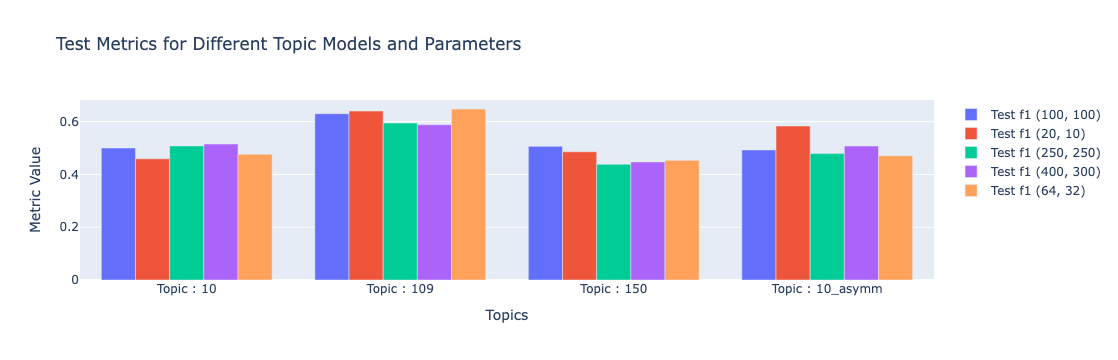

In [28]:
lda_comparison_experiment([10, max_topic, 150, 10], ['baseline', 'optimal topic model','arbitrarily high number of topics model','asymmetric_alpha_n_eta'], [lda_model_copy, lda_model, lda_model_more_topics, lda_model_copy_asymmetric])

In [30]:
#fig.write_html('graph_early_stopping.html')

## LDA modeling using TF-IDF for weighing keywords

In [31]:
from gensim.models import TfidfModel

In [32]:
corpus

[[(0, 1),
  (1, 1),
  (2, 2),
  (3, 1),
  (4, 1),
  (5, 2),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1)],
 [(2, 4),
  (5, 12),
  (6, 5),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 2),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 4),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 3),
  (20, 2),
  (21, 1),
  (22, 6),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 2),
  (27, 2)],
 [(5, 5),
  (9, 1),
  (10, 1),
  (20, 2),
  (27, 1),
  (28, 2),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 2),
  (38, 1),
  (39, 1),
  (40, 2),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 2),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 2),
  (51, 3),
  (52, 2),
  (53, 1)],
 [(0, 3),
  (3, 1),
  (5, 9),
  (9, 1),
  (10, 2),
  (12, 2),
  (52, 2),
  (54, 2),
  (55, 2),
  (56, 1),
  (57, 2),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 2),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 2)],
 [(0, 2),
  (5, 7),
  (6, 1

In [33]:
vars(id2word).keys()

dict_keys(['token2id', 'id2token', 'cfs', 'dfs', 'num_docs', 'num_pos', 'num_nnz', 'lifecycle_events'])

In [34]:
tfidf = TfidfModel(corpus=corpus, id2word=id2word)  # fit model

In [35]:
tf_idf_corpus = tfidf[corpus]

In [36]:
best_num_topics, _ = find_best_topic(tf_idf_corpus, id2word, data_words)

Coherence Score: 0.4377523737335418 and num_topics: 149
Coherence Score: 0.4396946537469575 and num_topics: 144
Coherence Score: 0.43673741951656286 and num_topics: 145
Coherence Score: 0.4248130687162946 and num_topics: 148
Coherence Score: 0.4373949592018188 and num_topics: 147
Coherence Score: 0.43412898260989735 and num_topics: 142
Coherence Score: 0.4371840222162442 and num_topics: 143
Coherence Score: 0.43040248576219503 and num_topics: 146
Coherence Score: 0.31515768903524227 and num_topics: 1
Coherence Score: 0.3139404688928214 and num_topics: 4
Coherence Score: 0.32160700883417553 and num_topics: 7
Coherence Score: 0.32874738611203613 and num_topics: 6
Coherence Score: 0.3109578657101296 and num_topics: 5
Coherence Score: 0.3121466754533714 and num_topics: 3
Coherence Score: 0.32190714678501864 and num_topics: 2
Coherence Score: 0.31889077230142787 and num_topics: 8
Coherence Score: 0.308135068984712 and num_topics: 9
Coherence Score: 0.34771027720263176 and num_topics: 11
Coh

In [37]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus=tf_idf_corpus,
                                       id2word=id2word,
                                       num_topics=best_num_topics,
                                      random_state = np.random.RandomState(42))

In [38]:
#Visualize using mmds as multidimentionality reduction technique
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(lda_model_tfidf, tf_idf_corpus, id2word, mds='mmds') 
p

/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
34     0.060882  0.122342       1        1  10.892221
36     0.109549  0.079030       2        1   4.645864
58    -0.085522 -0.007908       3        1   4.184315
49     0.055623 -0.075150       4        1   3.773050
72    -0.003759 -0.088442       5        1   3.318633
...         ...       ...     ...      ...        ...
21    -0.000948 -0.001737      77        1   0.454571
20    -0.000948 -0.001737      78        1   0.454571
53    -0.000948 -0.001737      79        1   0.454571
54    -0.000948 -0.001737      80        1   0.454571
0     -0.000948 -0.001737      81        1   0.454571

[81 rows x 5 columns], topic_info=         Term      Freq     Total Category  logprob  loglift
294       boy  5.000000  5.000000  Default  30.0000  30.0000
2         car  3.000000  3.000000  Default  29.0000  29.0000
94     street  5.000000  5.000000  Default  28.0000  28.0000
307      girl  2.000000  2.000000  Default  27.0000  27.0000
15    driving  2.000000  2.000000  Default  26.0000  26.0000
..        ...       ...       ...      ...      ...      ...
25       seen  0.005308  1.452635  Topic81  -6.8659  -0.2184
26   shooting  0.005308  2.707202  Topic81  -6.8659  -0.8409
27      woman  0.005308  2.559882  Topic81  -6.8659  -0.7850
28       arts  0.005308  2.519797  Topic81  -6.8659  -0.7692
29        bag  0.005308  1.297405  Topic81  -6.8659  -0.1054

[3608 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
337       9  0.654195    adjust
72        1  0.294408    around
28        2  0.396857      arts
28       19  0.396857      arts
466       1  0.437662  bathroom
...     ...       ...       ...
605      16  0.540373       wig
207       4  0.712650     world
208       4  0.678047   yawning
410       1  0.577795     young
410      11  0.288898     young

[132 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[35, 37, 59, 50, 73, 6, 63, 57, 15, 52, 42, 34, 78, 12, 75, 62, 77, 32, 30, 64, 14, 28, 2, 17, 4, 53, 76, 11, 41, 8, 39, 81, 33, 58, 60, 61, 18, 16, 13, 65, 66, 67, 68, 69, 70, 71, 72, 10, 74, 9, 7, 5, 3, 79, 80, 19, 20, 31, 56, 29, 36, 27, 38, 26, 40, 25, 24, 43, 44, 45, 46, 47, 48, 49, 23, 51, 22, 21, 54, 55, 1])

In [39]:
pyLDAvis.save_html(p, 'LDA_MLP_visualizations/lda_model_mmds_81_topics_tfidf.html')

In [40]:
max_topic

109

In [41]:
all_topic_counts, all_model_names,  all_models = [10, max_topic, 150, 10, best_num_topics], ['baseline', 'optimal topic model','arbitrarily high number of topics model','asymmetric_alpha_n_eta', 'tf_idf_model'], [lda_model_copy, lda_model, lda_model_more_topics, lda_model_copy_asymmetric, lda_model_tfidf]

/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.



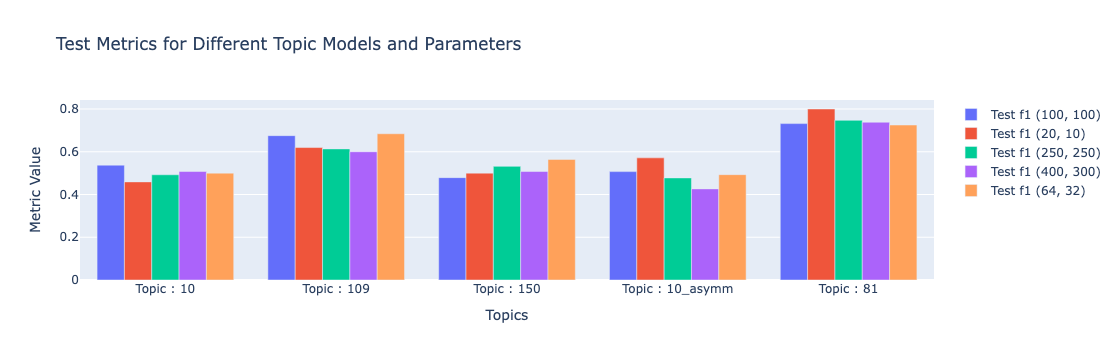

In [42]:
lda_comparison_experiment(all_topic_counts, all_model_names, all_models)

## LDA modeling using Bertopic for weighing keywords

In [43]:
from bertopic import BERTopic

In [44]:
data = df.Caption.values.tolist()
data_words = list(sent_to_words(data))
data_words = remove_stopwords(data_words, True)

In [45]:
data_words

['video bridge highway man sitting car talking another man car shown riding road falls',
 'car driving road man talking camera man shooting gun seen shooting man sitting plane talking man motorcycle man riding motorcycle holding gun man woman driving motorbike drive man woman driving car man riding motorcycle man riding motorcycle holding gun pulls man riding motorcycle car flipped man riding motorcycle car shown falling golf course man driving',
 'person walking staircase person walking stairs two boys playing wooden sticks stairs man sitting front door woman talking man holding sword man holding hand two men fighting swords martial arts studio man performing dance routine knife man practicing martial arts two swords punching bag',
 'man squatting picks piece cheese man talking another man field man talking another man talks camera man sitting looking camera man walking another man walking falls truck carrying large amount equipment truck carrying large amount equipment man suit runs 

In [46]:
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(data_words)

In [47]:
lda_model.get_document_topics(corpus[i], minimum_probability=0.0)

[(0, 0.0002866987),
 (1, 0.0002866987),
 (2, 0.0002866987),
 (3, 0.0002866987),
 (4, 0.0002866987),
 (5, 0.0002866987),
 (6, 0.0002866987),
 (7, 0.0002866987),
 (8, 0.0002866987),
 (9, 0.0002866987),
 (10, 0.0002866987),
 (11, 0.0002866987),
 (12, 0.0002866987),
 (13, 0.0002866987),
 (14, 0.0002866987),
 (15, 0.0002866987),
 (16, 0.0002866987),
 (17, 0.0002866987),
 (18, 0.0002866987),
 (19, 0.0002866987),
 (20, 0.0002866987),
 (21, 0.0002866987),
 (22, 0.0002866987),
 (23, 0.0002866987),
 (24, 0.0002866987),
 (25, 0.0002866987),
 (26, 0.0002866987),
 (27, 0.0002866987),
 (28, 0.0002866987),
 (29, 0.0002866987),
 (30, 0.0002866987),
 (31, 0.0002866987),
 (32, 0.0002866987),
 (33, 0.0002866987),
 (34, 0.0002866987),
 (35, 0.0002866987),
 (36, 0.0002866987),
 (37, 0.0002866987),
 (38, 0.0002866987),
 (39, 0.0002866987),
 (40, 0.0002866987),
 (41, 0.9690365),
 (42, 0.0002866987),
 (43, 0.0002866987),
 (44, 0.0002866987),
 (45, 0.0002866987),
 (46, 0.0002866987),
 (47, 0.0002866987),
 (48,

In [48]:
topic_model.get_document_info(data_words)

Document  Topic  \
0    video bridge highway man sitting car talking a...      2   
1    car driving road man talking camera man shooti...      2   
2    person walking staircase person walking stairs...     -1   
3    man squatting picks piece cheese man talking a...      3   
4    man knight armor talking another man battle sc...     -1   
..                                                 ...    ...   
326  man sitting table talking camera man sitting t...      4   
327  man holding box held man man woman playing gam...      6   
328  man wheelchair sitting room talking someone ma...      0   
329  little girl laying cat laying cat laying bed m...      6   
330  couple driving car driving woman boy back seat...      2   

                              Name  \
0          2_car_driving_woman_man   
1          2_car_driving_woman_man   
2    -1_man_woman_talking_standing   
3          3_man_shown_running_gun   
4    -1_man_woman_talking_standing   
..                             ...   
326  4_table_sitting_talking_woman   
327        6_woman_laying_bed_girl   
328  0_man_sitting_talking_another   
329        6_woman_laying_bed_girl   
330        2_car_driving_woman_man   

                                        Representation  \
0    [car, driving, woman, man, talking, drives, si...   
1    [car, driving, woman, man, talking, drives, si...   
2    [man, woman, talking, standing, group, another...   
3    [man, shown, running, gun, tank, another, figh...   
4    [man, woman, talking, standing, group, another...   
..                                                 ...   
326  [table, sitting, talking, woman, man, bar, gro...   
327  [woman, laying, bed, girl, talking, man, sleep...   
328  [man, sitting, talking, another, looking, chai...   
329  [woman, laying, bed, girl, talking, man, sleep...   
330  [car, driving, woman, man, talking, drives, si...   

                                   Representative_Docs  \
0    [woman talking man car talks camera man woman ...   
1    [woman talking man car talks camera man woman ...   
2    [woman looking camera staring camera man stand...   
3    [man shaving head air conditioner looking came...   
4    [woman looking camera staring camera man stand...   
..                                                 ...   
326  [man woman talking talking restaurant two men ...   
327  [woman talking man man talking man woman singi...   
328  [man talking another man room man standing roo...   
329  [woman talking man man talking man woman singi...   
330  [woman talking man car talks camera man woman ...   

                                           Top_n_words  Probability  \
0    car - driving - woman - man - talking - drives...     0.977288   
1    car - driving - woman - man - talking - drives...     0.808992   
2    man - woman - talking - standing - group - ano...     0.000000   
3    man - shown - running - gun - tank - another -...     0.993237   
4    man - woman - talking - standing - group - ano...     0.000000   
..                                                 ...          ...   
326  table - sitting - talking - woman - man - bar ...     1.000000   
327  woman - laying - bed - girl - talking - man - ...     1.000000   
328  man - sitting - talking - another - looking - ...     1.000000   
329  woman - laying - bed - girl - talking - man - ...     1.000000   
330  car - driving - woman - man - talking - drives...     1.000000   

     Representative_document  
0                      False  
1                      False  
2                      False  
3                      False  
4                      False  
..                       ...  
326                    False  
327                    False  
328                    False  
329                     True  
330                     True  

[331 rows x 8 columns]

In [49]:
topic_model.get_document_info(data_words).columns

Index(['Document', 'Topic', 'Name', 'Representation', 'Representative_Docs',
       'Top_n_words', 'Probability', 'Representative_document'],
      dtype='object')

In [50]:
topic_distr, _ = topic_model.approximate_distribution(data_words)

In [51]:
topic_distr.shape

(331, 7)

In [52]:
topic_distr

array([[0.17819632, 0.09205128, 0.35355452, ..., 0.14036482, 0.05063572,
        0.05316231],
       [0.11367185, 0.06785742, 0.4532048 , ..., 0.0908753 , 0.0093448 ,
        0.05737613],
       [0.11543106, 0.18131441, 0.04472554, ..., 0.12021349, 0.34773523,
        0.07190635],
       ...,
       [0.27415658, 0.15594099, 0.09083667, ..., 0.20014662, 0.08235006,
        0.10214351],
       [0.19801869, 0.15522779, 0.10210489, ..., 0.17639088, 0.03777915,
        0.29641972],
       [0.06263475, 0.12168854, 0.47655104, ..., 0.11696288, 0.05538825,
        0.08456566]])

In [53]:
topic_distr_list = list()
for topic_probs in topic_distr:
    topic_distr_list.append([(i, topic_prob) for i,topic_prob in enumerate(topic_probs)])

In [54]:
topic_distr.shape

(331, 7)

In [55]:
lda_model_tfidf.get_document_topics(corpus[0], minimum_probability=0.0)

[(0, 0.0010876681),
 (1, 0.0010876681),
 (2, 0.0010876681),
 (3, 0.0010876681),
 (4, 0.0010876681),
 (5, 0.0010876681),
 (6, 0.0010876681),
 (7, 0.0010876681),
 (8, 0.0010876681),
 (9, 0.0010876681),
 (10, 0.0010876681),
 (11, 0.0010876681),
 (12, 0.0010876681),
 (13, 0.0010876681),
 (14, 0.0010876681),
 (15, 0.0010876681),
 (16, 0.0010876681),
 (17, 0.0010876681),
 (18, 0.0010876681),
 (19, 0.0010876681),
 (20, 0.0010876681),
 (21, 0.0010876681),
 (22, 0.0010876681),
 (23, 0.0010876681),
 (24, 0.0010876681),
 (25, 0.0010876681),
 (26, 0.0010876681),
 (27, 0.0010876681),
 (28, 0.0010876681),
 (29, 0.0010876681),
 (30, 0.0010876681),
 (31, 0.16592093),
 (32, 0.0010876681),
 (33, 0.10277698),
 (34, 0.07513608),
 (35, 0.0010876681),
 (36, 0.0010876681),
 (37, 0.0010876681),
 (38, 0.0010876681),
 (39, 0.0010876681),
 (40, 0.0010876681),
 (41, 0.0010876681),
 (42, 0.0010876681),
 (43, 0.0010876681),
 (44, 0.0010876681),
 (45, 0.0010876681),
 (46, 0.0010876681),
 (47, 0.0010876681),
 (48, 0.

In [56]:
topic_distr[0]

array([0.17819632, 0.09205128, 0.35355452, 0.13203503, 0.14036482,
       0.05063572, 0.05316231])

In [57]:
topic_distr_list[0]

[(0, 0.17819632428308704),
 (1, 0.09205127907850408),
 (2, 0.35355451844282587),
 (3, 0.1320350292966589),
 (4, 0.140364817787391),
 (5, 0.05063571908790866),
 (6, 0.05316231202362443)]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

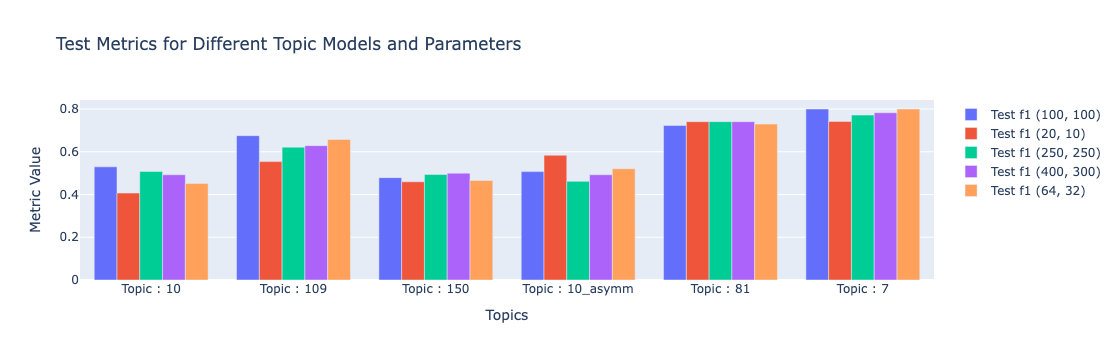

In [58]:
lda_comparison_experiment([10, max_topic, 150, 10, 81, 7], ['baseline', 'optimal topic model','arbitrarily high number of topics model','asymmetric_alpha_n_eta','tf_idf_model', 'bertopic'], [lda_model_copy, lda_model, lda_model_more_topics, lda_model_copy_asymmetric, lda_model_tfidf, topic_distr_list])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

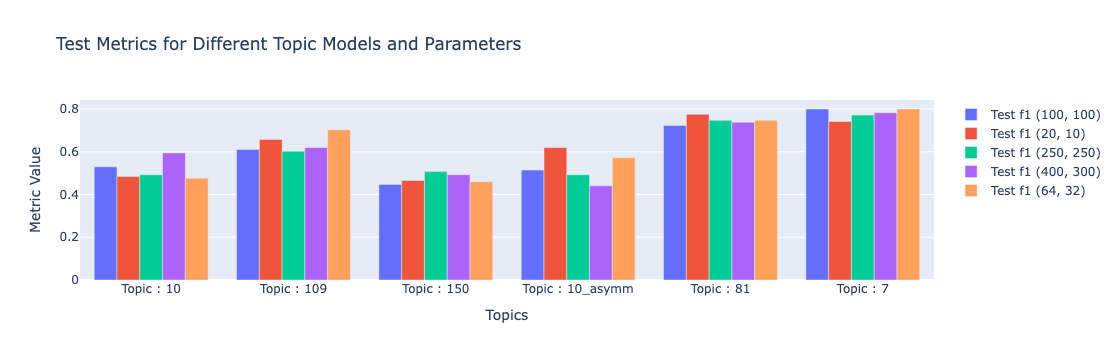

In [59]:
lda_comparison_experiment([10, max_topic, 150, 10, 81, 7], ['baseline', 'optimal topic model','arbitrarily high number of topics model','asymmetric_alpha_n_eta','tf_idf_model', 'bertopic'], [lda_model_copy, lda_model, lda_model_more_topics, lda_model_copy_asymmetric, lda_model_tfidf, topic_distr_list])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

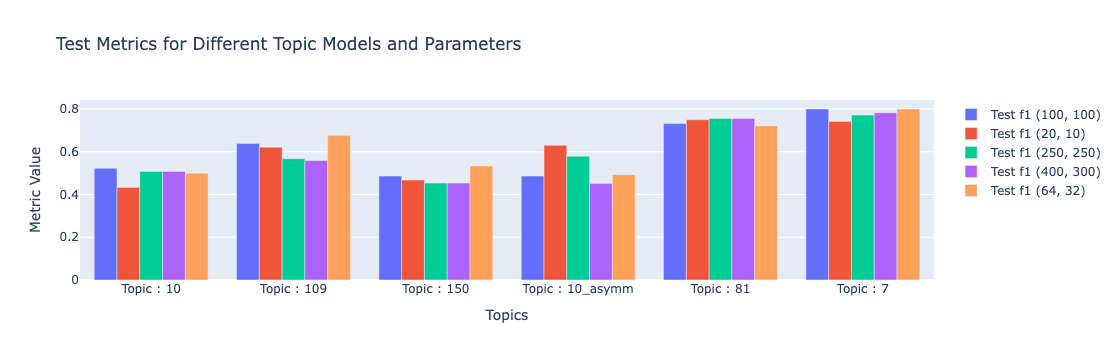

In [60]:
lda_comparison_experiment([10, max_topic, 150, 10, 81, 7], ['baseline', 'optimal topic model','arbitrarily high number of topics model','asymmetric_alpha_n_eta','tf_idf_model', 'bertopic'], [lda_model_copy, lda_model, lda_model_more_topics, lda_model_copy_asymmetric, lda_model_tfidf, topic_distr_list])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

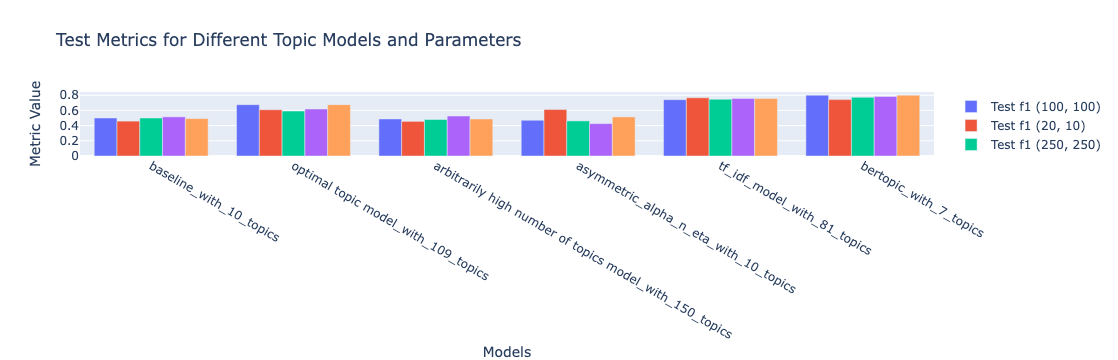

In [90]:
fig = lda_comparison_experiment([10, max_topic, 150, 10, 81, 7], ['baseline', 'optimal topic model','arbitrarily high number of topics model','asymmetric_alpha_n_eta','tf_idf_model', 'bertopic'], [lda_model_copy, lda_model, lda_model_more_topics, lda_model_copy_asymmetric, lda_model_tfidf, topic_distr_list])

In [91]:
fig.write_html('./LDA_MLP_visualizations/lda_all_models_compare.html')